# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [1]:
!pip install nlpaug -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 13.6 MB/s eta 0:00:00


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nlpaug.augmenter.word as naw
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Download the Dataset

In [4]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
100% 213k/213k [00:00<00:00, 760kB/s]
100% 213k/213k [00:00<00:00, 759kB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


In [5]:
df = pd.read_csv('spam.csv')
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [6]:
pd.set_option('display.max_colwidth', 1000)
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's https://link2.com,spam
3,U dun say so early hor... U c already then say... https://link2.com,ham
4,"Nah I don't think he goes to usf, he lives around here though https://link1.com",ham


In [7]:
df.sample(5)

,text,label
3310,HI DARLIN HOW WAS WORK DID U GET INTO TROUBLE? IJUST TALKED TO YOUR MUM ALL MORNING! I HAD A REALLY GOOD TIME LAST NIGHT IM GOIN OUT SOON BUT CALL ME IF U CAN https://link3.com,ham
3129,Ok. But i finish at 6.,ham
3809,"Aight, can you text me the address? https://link1.com",ham
3735,Hows the street where the end of library walk is?,ham
2493,they released another Italian one today and it has a cosign option https://link3.com,ham


(array([4825.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         747.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

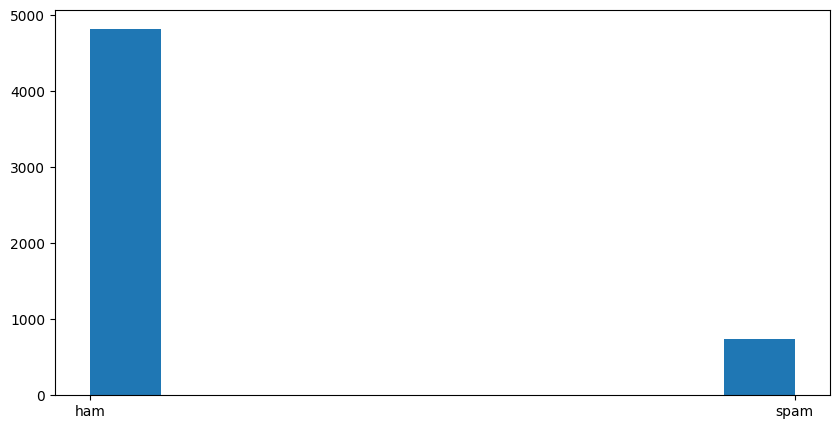

In [8]:
plt.figure(figsize=(10,5))
plt.hist(df['label'])

In [9]:
df[df['label']=='spam'].head()

,text,label
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's https://link2.com,spam
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv https://link2.com",spam
8,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,spam
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030 https://link2.com,spam
11,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info https://link1.com",spam


In [10]:
df.label.value_counts()

,count
label,
ham,4825
spam,747


In [11]:
df.isnull().sum()

,0
text,0
label,0


In [12]:
df.duplicated().sum()

183

In [13]:
df['text_length'] = df['text'].apply(lambda x: len(x))

In [14]:
df.head()

,text,label,text_length
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",ham,111
1,Ok lar... Joking wif u oni...,ham,29
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's https://link2.com,spam,173
3,U dun say so early hor... U c already then say... https://link2.com,ham,67
4,"Nah I don't think he goes to usf, he lives around here though https://link1.com",ham,79


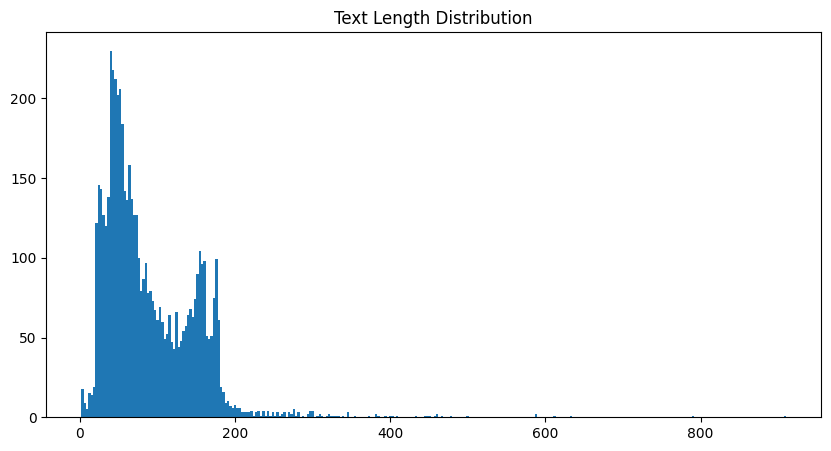

In [15]:
plt.figure(figsize=(10,5))
plt.hist(df['text_length'],bins=300)
plt.title('Text Length Distribution')
plt.show()

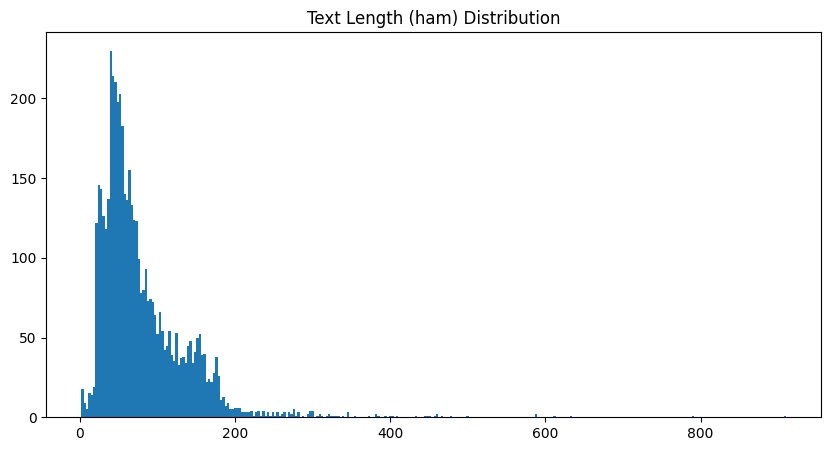

In [16]:
plt.figure(figsize=(10,5))
plt.hist(df[df['label']=='ham']['text_length'],bins=300)
plt.title('Text Length (ham) Distribution')
plt.show()

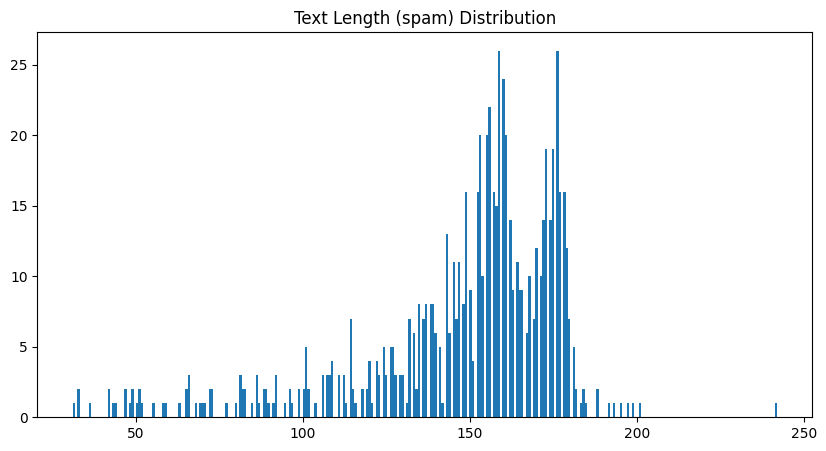

In [17]:
plt.figure(figsize=(10,5))
plt.hist(df[df['label']=='spam']['text_length'],bins=300)
plt.title('Text Length (spam) Distribution')
plt.show()

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [18]:
## There is no null values but there is duplicates so i will drop it

df.drop_duplicates(inplace=True)

In [19]:
df.sample(10)

,text,label,text_length
4712,Big brotherÛ÷s really scraped the barrel with this shower of social misfits https://link3.com,ham,94
4071,Loans for any purpose even if you have Bad Credit! Tenants Welcome. Call NoWorriesLoans.com on 08717111821 https://link2.com,spam,124
5239,"Jay wants to work out first, how's 4 sound?",ham,43
3468,All day working day:)except saturday and sunday.. https://link3.com,ham,67
715,When i have stuff to sell i.ll tell you,ham,39
937,K:)k.are you in college?,ham,24
3381,"Well, I meant as opposed to my drunken night of before https://link1.com",ham,72
4605,"Oh... Haha... Den we shld had went today too... Gee, nvm la... Kaiez, i dun mind goin jazz oso... Scared hiphop open cant catch up... https://link1.com",ham,152
1349,"FREE2DAY sexy St George's Day pic of Jordan!Txt PIC to 89080 dont miss out, then every wk a saucy celeb!4 more pics c PocketBabe.co.uk 0870241182716 å£3/wk",spam,155
3035,;-) ok. I feel like john lennon.,ham,32


In [20]:
df.shape

(5389, 3)

In [21]:
min_word_count = 8
max_word_count = 250

filtered_df = df[(df['text'].apply(lambda x: len(x.split())) >= min_word_count) & (df['text'].apply(lambda x: len(x.split())) <= max_word_count)]

In [22]:
filtered_df.shape

(4134, 3)

In [23]:
filtered_df.label.value_counts()

,count
label,
ham,3432
spam,702


In [24]:
stop_words = set(stopwords.words('english'))

In [25]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

In [26]:
filtered_df['text'] = filtered_df['text'].apply(clean_text)

<ipython-input-26-746bc8446125>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['text'].apply(clean_text)


In [27]:
df[(df['text'].apply(lambda x: len(x.split())) >= min_word_count) & (df['text'].apply(lambda x: len(x.split())) <= max_word_count)].head()

,text,label,text_length
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",ham,111
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's https://link2.com,spam,173
3,U dun say so early hor... U c already then say... https://link2.com,ham,67
4,"Nah I don't think he goes to usf, he lives around here though https://link1.com",ham,79
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv https://link2.com",spam,166


In [28]:
filtered_df.head()

,text,label,text_length
0,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,ham,111
2,free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs,spam,173
3,u dun say so early hor u c already then say,ham,67
4,nah i dont think he goes to usf he lives around here though,ham,79
5,freemsg hey there darling its been weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send to rcv,spam,166


In [32]:
filtered_df = filtered_df.reset_index()

In [36]:
filtered_df['text'] = filtered_df['text'].apply(lambda x:' '.join([word for word in x.split() if word not in stop_words]))

In [63]:
stemmer = PorterStemmer()

In [64]:
print(stemmer.stem('running'))

run


In [65]:
filtered_df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()])).head()

,text
0,go jurong point crazi avail bugi n great world la e buffet cine got amor wat
1,free entri wkli comp win fa cup final tkt st may text fa receiv entri questionstd txt ratetc appli over
2,u dun say earli hor u c alreadi say
3,nah dont think goe usf live around though
4,freemsg hey darl week word back id like fun still tb ok xxx std chg send rcv


In [66]:
filtered_df['text']  = filtered_df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [67]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_df['text'])
sequences = tokenizer.texts_to_sequences(filtered_df['text'])

In [75]:
max_length = 250
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [78]:
le = LabelEncoder()
labels = le.fit_transform(filtered_df['label'])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=True)

In [82]:
print("Training Data Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Testing Labels Shape:", y_test.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Labels Shape:", y_val.shape)

Training Data Shape: (2893, 250)
Training Labels Shape: (2893,)
Testing Data Shape: (621, 250)
Testing Labels Shape: (621,)
Validation Data Shape: (620, 250)
Validation Labels Shape: (620,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [103]:
from tensorflow.keras.metrics import F1Score

In [108]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision','recall'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [109]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [110]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [115]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=early_stopping)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0024 - precision: 1.0000 - recall: 0.9984 - val_loss: 0.1039 - val_precision: 0.9000 - val_recall: 0.9278
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0016 - precision: 0.9987 - recall: 0.9984 - val_loss: 0.1082 - val_precision: 0.9560 - val_recall: 0.8969
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.6243e-04 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1205 - val_precision: 0.9565 - val_recall: 0.9072


# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [112]:
model.evaluate(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0720 - precision: 0.9305 - recall: 0.9124


[0.09103358536958694, 0.932692289352417, 0.9150943160057068]

In [113]:
pred = model.predict(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [117]:
print(confusion_matrix(y_test, pred.round()))

[[508   7]
 [  9  97]]


In [118]:
print(classification_report(y_test, pred.round()))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       515
           1       0.93      0.92      0.92       106

    accuracy                           0.97       621
   macro avg       0.96      0.95      0.95       621
weighted avg       0.97      0.97      0.97       621



# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [123]:
corpus = 'congratulation, join us our new website, we offer free gifts just for you http://wewill.hackyou'
example_text = clean_text(corpus)
example_text = ' '.join([word for word in example_text.split() if word not in stop_words])
example_text = stemmer.stem(example_text)
example_text = tokenizer.texts_to_sequences([example_text])
example_text = pad_sequences(example_text, maxlen=max_length, padding='post', truncating='post')

pred = model.predict(example_text)
if pred[0][0] > 0.5:
  print("spam sentiment")
else:
  print("ham sentiment")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
spam sentiment


In [125]:
corpus = 'Hi there, see you tommorow at work do not come late'
example_text = clean_text(corpus)
example_text = ' '.join([word for word in example_text.split() if word not in stop_words])
example_text = stemmer.stem(example_text)
example_text = tokenizer.texts_to_sequences([example_text])
example_text = pad_sequences(example_text, maxlen=max_length, padding='post', truncating='post')

pred = model.predict(example_text)
if pred[0][0] > 0.5:
  print("spam sentiment")
else:
  print("ham sentiment")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ham sentiment


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

# Text Preprocessing:
I started by removing duplicates and filtering text by length to ensure consistency and reduce noise Then, I cleaned the text by removing URLs, special characters, and punctuation, and converting everything to lowercase.

removed common English stopwords as they don't contribute much to the meaning of the text.

Finally, I applied stemming to reduce words to their root form, which helps in reducing the vocabulary size and improving generalization and improve the model's ability to focus on important words.

#model selection

I chose a bidirectional LSTM model because it is effective in capturing long-range dependencies in text data.
Bidirectional LSTMs process the input sequence in both directions, allowing the model to learn contextual information from both past and future words.

#number of layers or units for the model

The number of layers and units were chosen through experimentation and considering the complexity of the dataset.
The initial embedding layer size of 128 was chosen to capture the semantic meaning of the words.
The LSTM layers with 128 and 64 units were used to learn the temporal dependencies in the text.
The dense layer with 64 units helps in further processing the information before the final output.
I started with a small number of units and then increasing to capture the data complixity

#evaluation methods
I used accuracy, precision, recall,f1-score ,and confusion matrix to evaluate the model's performance.
and the classification report to show them all in a pretty understandable way
the precision, recall and f1-score are important to evaluate any classification model


#Does your model show signs of overfitting or underfitting? How do you know?
yes there was signs of overfitting because the model's metrics in the training process shows a better values than the validation process and this indecates an overfitting and that's why i used early stopping to avoid it and get the best parameters

#What changes could you make to improve the model and fix overfitting or underfitting?

as a future work an augumenter can be used to fix the data unbalanced, and using lemmatization to see if it gives better results than the stemmer, to avoid underfitting the model complixity may be increased and and the data should be filltered to get shorter sequenses, to avoid overfitting some techuniqes can be used such as dropout, batchnormalization, etc to insure generalization.